This post is going to introduce logistic regression with an emphasis on explaining the coefficients in the output of Python's statsmodels.

In [1]:
#| code-fold: true
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Background

Logistic regression is used to solve the classification problem. Classification problem means the dependent variable is categorical. For example, we can build a machine learning model to predict whether a student will be admitted to college based on metrics like his or her GPA, standardized test scores. If we formulate a classification problem in mathematical form, we have:

$$y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$$,

where y is a categorical variable, like whether you are admited or not.

One way to approach this problem is by using linear regression. However, we would like our algorithm will output a number between 0 and 1, which can indicate the probability of an observation belonging to a certain category. Linear regression does not satisfy this requirement as it might output values smaller than 0 or larger than 1.

One solution is to solve this problem is to transform the value of $\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$ to the range of [0,1]. We can do this with the logistic function:
$$f(x)=\frac{e^{x}}{1+e^{x}}$$.

To show that logistic regression will make a number between 0 and 1. Let's make a plot of it.

In [2]:
def logit(x):
    return np.exp(x)/(1+np.exp(x))

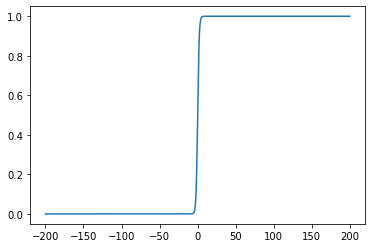

In [3]:
x = np.arange(-200, 200, 0.1)
y = logit(x)
plt.plot(x,y);

As we can see, the logit function has a S shape and is bounded by 0 and 1. When x is approaching positive infinity, the logit of x approaches 1. When x is approaching negative infinity, the logit of x approaches 0.

Thus, we can transform the value of $\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}$ to:

$$
p(X)=\frac{e^{\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}}}{1+e^{\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2}}}
$$

Now the output of our regression will fall between zero and one. Since we the logistic function to achieve this, the regression is called logistic regression. Before jumping into the details of behind it, let's first we how to run it in python.

### 2. Python Implementation of Logistic Regression

For this post, we are going to use a college admission dataset from [UCLA's Institute for Digital Research & Education](https://stats.idre.ucla.edu/). We want to use a student's GRE score, GPA, and rank to predict whether the student will be admitted. 

In [4]:
df = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

In [5]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


We are going to use the statsmodel package to run the logistic regression. We choose statsmodel because its interface and summary of the result are more similar to other statistical software, like R and Stata.

In [6]:
import statsmodels.formula.api as smf

In [7]:
#collapse_output
mod = smf.logit(formula='admit ~ gre + gpa + rank', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6


In [8]:
print(mod.summary())

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Feb 2021   Pseudo R-squ.:                 0.08107
Time:                        09:16:16   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 8.207e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4495      1.133     -3.045      0.002      -5.670      -1.229
gre            0.0023      0.001      2.101      0.036       0.000       0.004
gpa            0.7770      0.327      2.373      0.0

### 3. Interpretation of the Result

#### 3.1 Prediction

Let's make a prediction for a student with GRE 300, GPA 2, and rank 4. 

In [9]:
#the 1 is the constant term for intercept
a_new_student = np.array([1, 300, 2, 4])

We extract the parameters from the logistic regression model to make the prediction.

In [10]:
model_parameters = mod.params.values
model_parameters

array([-3.44954840e+00,  2.29395950e-03,  7.77013574e-01, -5.60031387e-01])

Note that the following calculation can be made much easier with matrix multiplication with code like ```a_new_student @ model_parameters```.

In [11]:
pred = 0
for i in range(4):
    pred += model_parameters[i] * a_new_student[i]
pred

-3.4474589462957206

Note that the result is **negative**. Did we say in the previous section the logistic regression guarantees a prediction between 0 and 1? Then why do we get this negative prediction? To understand this, we need to understand the relationship between three terms - probability, odd, and log-odd.

#### 3.2 Probability, odd, log-odd

Let $k = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3}$. As we discussed in section 1, we have: $p(X)=\frac{e^{k}}{1+e^{k}}$, which is the probability of X belonging to a certain class.

Then, $p(x) + p(x)e^k = e^k$. Then $p(x) = e^k - p(x)e^k = e^k(1-p(x))$. Thus, $e^{k} = \frac{p(x)}{1-p(x)}$.
The quantity $\frac{p(x)}{1-p(x)}$ is called the *odds*.

Taking log from both side the odds equation, we have $k= log(\frac{p(x)}{1-p(x)})$. This quantity $log(\frac{p(x)}{1-p(x)})$ the *log-odds*.

Bringing back the value of k, we have: $log(\frac{p(x)}{1-p(x)}) =  \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3}$. 

What we are actually evaluating when running the python code in the section is the equation above. Thus, the prediction we made is **not** the probability, but the **log-odds**.

To evaluate the probability, we can put the log-odds we predict back to the formula $p(X)=\frac{e^{k}}{1+e^{k}}$, as k is the log-odd we predict.

In code, we have:

In [12]:
def prob_from_log_odd(log_odds):
    prob = np.exp(log_odds)/(1+np.exp(log_odds))
    return prob

Using the prediction we have in section 3.1, we have:

In [13]:
print("The log odd is: ", pred)
print("The probability is: ", prob_from_log_odd(pred))

The log odd is:  -3.4474589462957206
The probability is:  0.03084472943016926


Note that the probability is about 0.03, which is between 0 and 1. To determine whether the student will be admitted or not, we usually set a 0.5 as the threshold. For students with predicted probability lower than 0.5, we will predict the result as reject. Otherwise, we will predict the result as admit.

#### 3.3 Coefficient Explanation

Based on the discussion in section 3.2, the explanation of a specific coefficient of the logistic regression is that given all other variables being the same, how much log-odd will change given one unit increase of the independent variable. For example, the coefficient for gre is about 0.0023, which can be interpreted as given all other variables being the same, one additional GRE score will lead to a 0.0023 increase of the log odd.

### 4. Estimation Method

One question we did not answer so far is that how do we get the estimation of these coefficients for logistic regression. The estimation uses a statistical method called maximum likelihood estimation. The details for this method is beyond the scope of this post. The book [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) gives a detailed discussion of the estimation process in section 4.4. A Python implementation of the estimation from scratch can be found in this [post](https://beckernick.github.io/logistic-regression-from-scratch/).